# Early Exit Classification: GPT2-medium vs Llama3

This notebook implements and compares **early exit strategies** for text classification using:
1. **GPT2-medium** (24 layers, ~355M parameters)
2. **Llama3** (16 layers for 1B, 28 layers for 3B, 32 layers for 8B)

## How it works:
- Uses **verbalizer-based classification**: maps class labels to tokens (e.g., "positive"/"negative")
- **Early exit**: if the model is confident enough at an intermediate layer, skip remaining layers
- **Threshold-based**: exits when softmax probability exceeds a confidence threshold

## Models Comparison:
| Model | Parameters | Layers | Type |
|-------|-----------|--------|------|
| GPT2-medium | 355M | 24 | Decoder-only |
| Llama3.2-1B | 1B | 16 | Decoder-only |
| Llama3.2-3B | 3B | 28 | Decoder-only |

## Requirements:
```bash
pip install torch transformers datasets
```

For Llama3 access, you need to:
1. Accept the license at https://huggingface.co/meta-llama
2. Login with `huggingface-cli login`


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
import os


# project_path = '/content/MyDrive/ColabNotebooks/25FALL_MLACC/adaptive-inference-llm'
# project_path = '/content/drive/MyDrive/ColabNotebooks/25FALL_MLACC/adaptive-inference-llm/'
project_path = '/content/drive/MyDrive/Colab Notebooks/25FALL_MLACC/Final_project/adaptive-inference-llm/'
if project_path not in sys.path:
    sys.path.append(project_path)

#Print
print(sys.path)
print("Folder includes:", os.listdir(project_path))

['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/tmp/tmp23i6qtmr', '/content/drive/MyDrive/Colab Notebooks/25FALL_MLACC/Final_project/adaptive-inference-llm/']
Folder includes: ['README.md', 'analysis-early_exit_classification.ipynb', 'early_exit_classification(with prompt).ipynb', 'early_exit_classification(no prompt) - gpt2-base.ipynb', 'test.ipynb', 'strategies', 'Modern BERT', 'models', '.git', 'evaluation', '.ipynb_checkpoints', 'early_exit_classification(no prompt)-GPT2-medium.ipynb', 'Copy of early_exit_classification(no prompt)-GPT2-medium.ipynb']


In [ ]:
! git clone https://github.com/komalniraula/adaptive-inference-llm.git

Cloning into 'adaptive-inference-llm'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# =====================================================
# COMPREHENSIVE COMPARISON: GPT2-medium vs Llama (matched scale)
# =====================================================

import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM

# -----------------------------
# Verbalizers (make consistent)
# -----------------------------
# Use leading space for stability across BPE tokenizers
verbalizers_comparison = {
    "sst2": {
        0: [" negative"],
        1: [" positive"],
    },
    "amazon_polarity": {
        0: [" negative"],
        1: [" positive"]
    }
}

# -----------------------------
# Model configurations
# -----------------------------
GPT2_MODEL  = "gpt2-medium"
LLAMA_MODEL = "unsloth/Llama-3.2-1B"   # 16 layers, not gated, closer to GPT2-medium

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -----------------------------
# Dataset loaders (your repo)
# -----------------------------
from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.amazon import load_amazon_polarity

dataset_loaders_comparison = [
    ("sst2", load_sst2, "classification"),
    ("amazon_polarity", load_amazon_polarity, "classification")
]

# -----------------------------
# Load datasets (cache)
# -----------------------------
cached_datasets_comparison = {}
print("Loading datasets for comparison...\n")
for name, loader, task in dataset_loaders_comparison:
    print(f"Loading {name}...")
    cached_datasets_comparison[name] = {
        "data": loader(number=300),  # reduced for speed
        "task": task
    }
print("\nDatasets loaded.\n")


# =====================================================
# Utilities
# =====================================================

def extract_text_label(sample):
    if isinstance(sample, dict):
        if "text" in sample:
            return sample["text"], sample["label"]
        elif "sentence" in sample:
            return sample["sentence"], sample["label"]
        elif "input_text" in sample:
            return sample["input_text"], sample["label"]
    if isinstance(sample, (tuple, list)):
        return sample[0], sample[1]
    raise ValueError("Unknown sample format:", sample)


# =====================================================
# Stable Llama classifiers (hidden_states-based early exit)
# =====================================================

class Llama3EarlyExitClassifier(nn.Module):
    def __init__(self, model_name, exit_layers, threshold, verbalizers, device="cuda"):
        super().__init__()
        self.device = device

        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            device_map="auto" if device == "cuda" else None,
            output_hidden_states=True,
        )
        self.model.eval()

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.num_layers = int(self.model.config.num_hidden_layers)

        # exit_layers are 1..L (hidden_states[0] is embeddings)
        self.exit_layers = sorted([int(l) for l in exit_layers if 1 <= int(l) <= self.num_layers])
        if len(self.exit_layers) == 0:
            self.exit_layers = [self.num_layers]

        self.threshold = float(threshold)
        self.verbalizers = verbalizers

        # Precompute verbalizer token ids
        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            tok_ids_map = {}
            for cls, words in class_map.items():
                token_lists = []
                for w in words:
                    ww = w if w.startswith(" ") else (" " + w)
                    ids = self.tokenizer.encode(ww, add_special_tokens=False)
                    if len(ids) > 0:
                        token_lists.append(ids)
                tok_ids_map[int(cls)] = token_lists
            self.verbalizer_token_ids[dataset] = tok_ids_map

    @torch.no_grad()
    def _scores_from_logits(self, logits_1d, verbalizer_map):
        class_keys = sorted(verbalizer_map.keys())
        scores = []
        for cls in class_keys:
            tok_lists = verbalizer_map[cls]
            vals = []
            for tok_list in tok_lists:
                idx = torch.tensor(tok_list, dtype=torch.long, device=logits_1d.device)
                vals.append(logits_1d[idx].mean())
            scores.append(torch.stack(vals).mean() if len(vals) else torch.tensor(0.0, device=logits_1d.device))
        return torch.stack(scores), class_keys

    @torch.no_grad()
    def classify(self, text, dataset_name):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=256)

        # device_map="auto" safe placement
        model_device = next(self.model.parameters()).device
        inputs = {k: v.to(model_device) for k, v in inputs.items()}

        out = self.model(**inputs, output_hidden_states=True, use_cache=False)
        hidden_states = out.hidden_states

        verbalizer_map = self.verbalizer_token_ids[dataset_name]

        # early exit
        for layer in self.exit_layers:
            h = hidden_states[layer][0, -1, :]       # [hidden]
            h = self.model.model.norm(h)             # Llama: norm before head
            logits = self.model.lm_head(h)           # [vocab]

            class_scores, class_keys = self._scores_from_logits(logits, verbalizer_map)
            probs = torch.softmax(class_scores, dim=-1)

            pred_idx = int(torch.argmax(probs).item())
            pred = int(class_keys[pred_idx])
            conf = float(probs[pred_idx].item())

            if conf >= self.threshold:
                return pred, int(layer), conf

        # final layer
        last_layer = self.num_layers
        h = hidden_states[last_layer][0, -1, :]
        h = self.model.model.norm(h)
        logits = self.model.lm_head(h)

        class_scores, class_keys = self._scores_from_logits(logits, verbalizer_map)
        probs = torch.softmax(class_scores, dim=-1)

        pred_idx = int(torch.argmax(probs).item())
        pred = int(class_keys[pred_idx])
        conf = float(probs[pred_idx].item())
        return pred, int(last_layer), conf


class Llama3BaselineClassifier(nn.Module):
    def __init__(self, model_name, verbalizers, device="cuda"):
        super().__init__()
        self.device = device

        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            device_map="auto" if device == "cuda" else None,
            output_hidden_states=True,
        )
        self.model.eval()

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.num_layers = int(self.model.config.num_hidden_layers)

        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            tok_ids_map = {}
            for cls, words in class_map.items():
                token_lists = []
                for w in words:
                    ww = w if w.startswith(" ") else (" " + w)
                    ids = self.tokenizer.encode(ww, add_special_tokens=False)
                    if len(ids) > 0:
                        token_lists.append(ids)
                tok_ids_map[int(cls)] = token_lists
            self.verbalizer_token_ids[dataset] = tok_ids_map

    @torch.no_grad()
    def _scores_from_logits(self, logits_1d, verbalizer_map):
        class_keys = sorted(verbalizer_map.keys())
        scores = []
        for cls in class_keys:
            tok_lists = verbalizer_map[cls]
            vals = []
            for tok_list in tok_lists:
                idx = torch.tensor(tok_list, dtype=torch.long, device=logits_1d.device)
                vals.append(logits_1d[idx].mean())
            scores.append(torch.stack(vals).mean() if len(vals) else torch.tensor(0.0, device=logits_1d.device))
        return torch.stack(scores), class_keys

    @torch.no_grad()
    def classify(self, text, dataset_name):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
        model_device = next(self.model.parameters()).device
        inputs = {k: v.to(model_device) for k, v in inputs.items()}

        out = self.model(**inputs, output_hidden_states=True, use_cache=False)
        h = out.hidden_states[-1][0, -1, :]          # last layer, last token
        h = self.model.model.norm(h)
        logits = self.model.lm_head(h)

        verbalizer_map = self.verbalizer_token_ids[dataset_name]
        class_scores, class_keys = self._scores_from_logits(logits, verbalizer_map)
        probs = torch.softmax(class_scores, dim=-1)

        pred_idx = int(torch.argmax(probs).item())
        pred = int(class_keys[pred_idx])
        conf = float(probs[pred_idx].item())
        return pred, self.num_layers, conf


# =====================================================
# Evaluation
# =====================================================

def evaluate_model(model, dataset, dataset_name, model_type="gpt2"):
    correct = 0
    total = 0
    layers_used = []
    total_tokens = 0

    start = time.time()

    for sample in dataset:
        text, label = extract_text_label(sample)

        try:
            pred, layer, conf = model.classify(text, dataset_name)
            correct += int(pred == label)
            total += 1
            layers_used.append(layer)

            # token counting (no special tokens)
            total_tokens += len(model.tokenizer(text, add_special_tokens=False)["input_ids"])

        except Exception as e:
            # keep going but show what failed
            print(f"Error processing sample: {type(e).__name__}: {e}")
            continue

    end = time.time()
    if total == 0:
        return None

    latency = (end - start) / total

    return {
        "metric": "accuracy",
        "score": correct / total,
        "avg_latency_sec": latency,
        "tokens_per_sec": total_tokens / (end - start),
        "avg_layers_used": float(np.mean(layers_used)) if len(layers_used) else float("nan"),
        "num_samples": total
    }


# =====================================================
# RUN COMPARISON
# =====================================================

comparison_results = []

# ------ GPT2-medium ------
print("\n" + "="*60)
print("Running GPT2-medium Experiments")
print("="*60)

gpt2_baseline = GPT2BaselineClassifier(
    model_name=GPT2_MODEL,
    verbalizers=verbalizers_comparison
)

for name, meta in cached_datasets_comparison.items():
    print(f"\nTesting GPT2 BASELINE on {name}...")
    result = evaluate_model(gpt2_baseline, meta["data"], name, "gpt2")
    if result:
        comparison_results.append({
            "model": "GPT2-medium",
            "dataset": name,
            "mode": "baseline",
            "threshold": None,
            "exit_layers": "all",
            **result
        })
        print(f"  Accuracy: {result['score']:.4f}, Latency: {result['avg_latency_sec']:.4f}s")

gpt2_exit_layers = [4, 8, 12, 16, 20]  # GPT2-medium has 24 layers
gpt2_thresholds = [0.6, 0.7, 0.8, 0.9]

for th in gpt2_thresholds:
    gpt2_early = GPT2EarlyExitClassifier(
        model_name=GPT2_MODEL,
        exit_layers=gpt2_exit_layers,
        threshold=th,
        verbalizers=verbalizers_comparison
    )

    for name, meta in cached_datasets_comparison.items():
        print(f"\nTesting GPT2 Early Exit (th={th}) on {name}...")
        result = evaluate_model(gpt2_early, meta["data"], name, "gpt2")
        if result:
            comparison_results.append({
                "model": "GPT2-medium",
                "dataset": name,
                "mode": "early_exit",
                "threshold": th,
                "exit_layers": str(gpt2_exit_layers),
                **result
            })
            print(f"  Accuracy: {result['score']:.4f}, Layers: {result['avg_layers_used']:.1f}, Latency: {result['avg_latency_sec']:.4f}s")


# ------ Llama (matched scale) ------
print("\n" + "="*60)
print("Running Llama Experiments")
print("="*60)

try:
    llama_baseline = Llama3BaselineClassifier(
        model_name=LLAMA_MODEL,
        verbalizers=verbalizers_comparison,
        device=device
    )

    llama_num_layers = llama_baseline.num_layers
    print(f"Llama model ({LLAMA_MODEL}) has {llama_num_layers} layers")

    # Baseline
    for name, meta in cached_datasets_comparison.items():
        print(f"\nTesting Llama BASELINE on {name}...")
        result = evaluate_model(llama_baseline, meta["data"], name, "llama")
        if result:
            comparison_results.append({
                "model": f"Llama-{LLAMA_MODEL.split('/')[-1]}",
                "dataset": name,
                "mode": "baseline",
                "threshold": None,
                "exit_layers": "all",
                **result
            })
            print(f"  Accuracy: {result['score']:.4f}, Latency: {result['avg_latency_sec']:.4f}s")

    # Early Exit: map GPT2 exit ratios to llama layers (fairer)
    ratios = [4/24, 8/24, 12/24, 16/24, 20/24]
    llama_exit_layers = sorted({max(1, min(llama_num_layers, int(round(r * llama_num_layers)))) for r in ratios})
    print("Using llama exit layers:", llama_exit_layers)

    llama_thresholds = [0.6, 0.7, 0.8, 0.9]
    for th in llama_thresholds:
        llama_early = Llama3EarlyExitClassifier(
            model_name=LLAMA_MODEL,
            exit_layers=llama_exit_layers,
            threshold=th,
            verbalizers=verbalizers_comparison,
            device=device
        )

        for name, meta in cached_datasets_comparison.items():
            print(f"\nTesting Llama Early Exit (th={th}) on {name}...")
            result = evaluate_model(llama_early, meta["data"], name, "llama")
            if result:
                comparison_results.append({
                    "model": f"Llama-{LLAMA_MODEL.split('/')[-1]}",
                    "dataset": name,
                    "mode": "early_exit",
                    "threshold": th,
                    "exit_layers": str(llama_exit_layers),
                    **result
                })
                print(f"  Accuracy: {result['score']:.4f}, Layers: {result['avg_layers_used']:.1f}, Latency: {result['avg_latency_sec']:.4f}s")

except Exception as e:
    import traceback
    print("\nError running Llama experiments:")
    traceback.print_exc()
    print("Skipping Llama experiments.")


# -----------------------------
# Results table
# -----------------------------
df_comparison = pd.DataFrame(comparison_results)
print("\n" + "="*60)
print("COMPARISON RESULTS")
print("="*60)
df_comparison


Using device: cuda
Loading datasets for comparison...

Loading sst2...
Loading amazon_polarity...

Datasets loaded.


Running GPT2-medium Experiments

Testing GPT2 BASELINE on sst2...
  Accuracy: 0.7200, Latency: 0.6462s

Testing GPT2 BASELINE on amazon_polarity...
  Accuracy: 0.2167, Latency: 1.1137s

Testing GPT2 Early Exit (th=0.6) on sst2...
  Accuracy: 0.5033, Layers: 4.3, Latency: 0.1091s

Testing GPT2 Early Exit (th=0.6) on amazon_polarity...
  Accuracy: 0.4100, Layers: 5.5, Latency: 0.2590s

Testing GPT2 Early Exit (th=0.7) on sst2...
  Accuracy: 0.5533, Layers: 5.3, Latency: 0.1376s

Testing GPT2 Early Exit (th=0.7) on amazon_polarity...
  Accuracy: 0.3200, Layers: 7.7, Latency: 0.3666s

Testing GPT2 Early Exit (th=0.8) on sst2...
  Accuracy: 0.5733, Layers: 8.8, Latency: 0.2252s

Testing GPT2 Early Exit (th=0.8) on amazon_polarity...
  Accuracy: 0.2533, Layers: 10.5, Latency: 0.4849s

Testing GPT2 Early Exit (th=0.9) on sst2...
  Accuracy: 0.5933, Layers: 14.7, Latency: 0.362

,model,dataset,mode,threshold,exit_layers,metric,score,avg_latency_sec,tokens_per_sec,avg_layers_used,num_samples
0,GPT2-medium,sst2,baseline,NaN,all,accuracy,0.720000,0.646202,36.304440,24.000000,300
1,GPT2-medium,amazon_polarity,baseline,NaN,all,accuracy,0.216667,1.113688,85.888824,24.000000,300
2,GPT2-medium,sst2,early_exit,0.6,"[4, 8, 12, 16, 20]",accuracy,0.503333,0.109063,215.105386,4.320000,300
3,GPT2-medium,amazon_polarity,early_exit,0.6,"[4, 8, 12, 16, 20]",accuracy,0.410000,0.258992,369.329793,5.506667,300
4,GPT2-medium,sst2,early_exit,0.7,"[4, 8, 12, 16, 20]",accuracy,0.553333,0.137647,170.435826,5.346667,300
5,GPT2-medium,amazon_polarity,early_exit,0.7,"[4, 8, 12, 16, 20]",accuracy,0.320000,0.366615,260.909502,7.746667,300
6,GPT2-medium,sst2,early_exit,0.8,"[4, 8, 12, 16, 20]",accuracy,0.573333,0.225245,104.153050,8.826667,300
7,GPT2-medium,amazon_polarity,early_exit,0.8,"[4, 8, 12, 16, 20]",accuracy,0.253333,0.484910,197.259989,10.546667,300
8,GPT2-medium,sst2,early_exit,0.9,"[4, 8, 12, 16, 20]",accuracy,0.593333,0.362805,64.662858,14.666667,300
9,GPT2-medium,amazon_polarity,early_exit,0.9,"[4, 8, 12, 16, 20]",accuracy,0.216667,0.630298,151.758977,13.866667,300


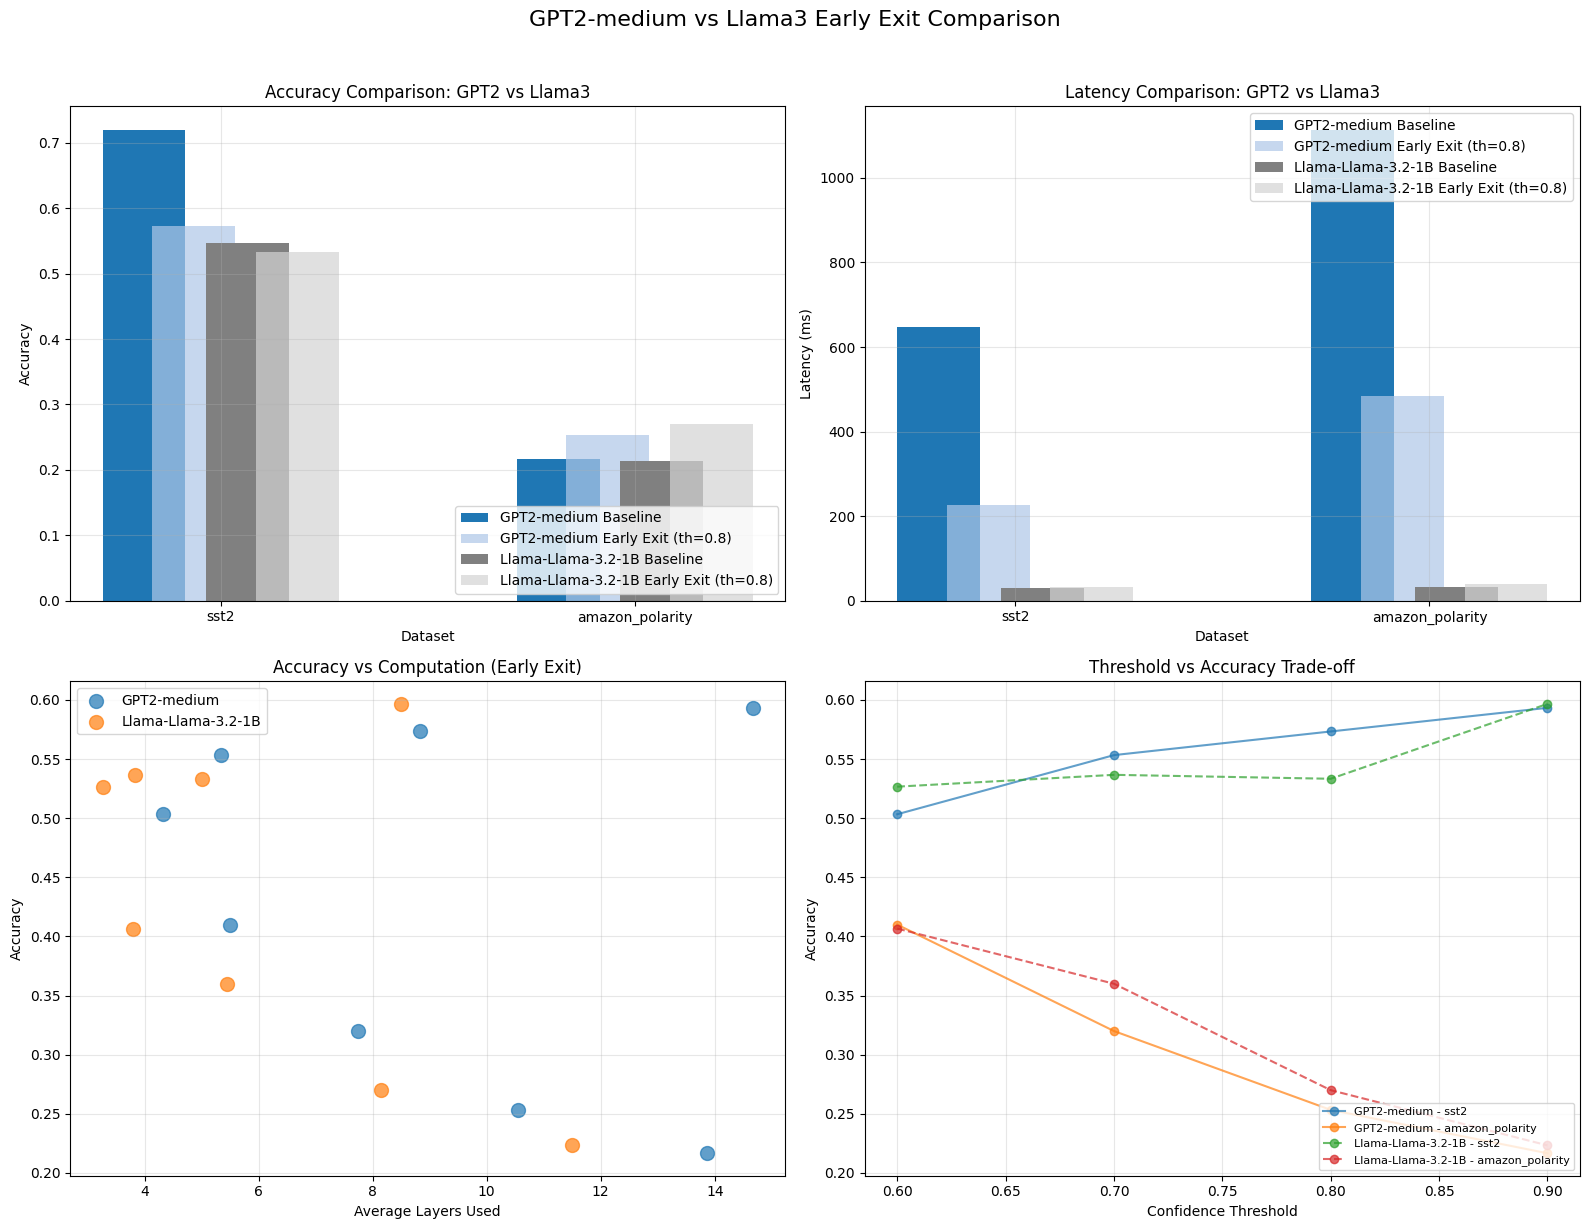


SUMMARY: Best Early Exit Configuration (threshold=0.8)


,Model,Dataset,Baseline Acc,Early Exit Acc,Acc Drop,Speedup,Avg Layers
0,GPT2-medium,sst2,0.720,0.573,0.147,2.87x,8.8
1,GPT2-medium,amazon_polarity,0.217,0.253,-0.037,2.30x,10.5
2,Llama-Llama-3.2-1B,sst2,0.547,0.533,0.013,0.95x,5.0
3,Llama-Llama-3.2-1B,amazon_polarity,0.213,0.270,-0.057,0.86x,8.1


In [ ]:
# =====================================================
# VISUALIZATION: GPT2 vs Llama3 Comparison
# =====================================================

import matplotlib.pyplot as plt

# Check if we have comparison results
if len(comparison_results) > 0:

    datasets = df_comparison['dataset'].unique()
    models = df_comparison['model'].unique()

    # Color maps for models
    model_colors = {
        'GPT2-medium': {'baseline': '#1f77b4', 'early_exit': '#aec7e8'},
        'Llama3-Llama-3.2-1B': {'baseline': '#ff7f0e', 'early_exit': '#ffbb78'}
    }

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # ---- Plot 1: Accuracy Comparison (Bar Chart) ----
    ax1 = axes[0, 0]
    x = np.arange(len(datasets))
    width = 0.2

    for i, model in enumerate(models):
        df_model = df_comparison[df_comparison['model'] == model]

        # Baseline
        baseline_scores = []
        for ds in datasets:
            score = df_model[(df_model['dataset'] == ds) & (df_model['mode'] == 'baseline')]['score'].values
            baseline_scores.append(score[0] if len(score) > 0 else 0)

        # Best early exit (threshold 0.8)
        early_scores = []
        for ds in datasets:
            score = df_model[(df_model['dataset'] == ds) & (df_model['mode'] == 'early_exit') & (df_model['threshold'] == 0.8)]['score'].values
            early_scores.append(score[0] if len(score) > 0 else 0)

        offset = i * 0.25 - 0.125
        color = list(model_colors.get(model, {'baseline': 'gray', 'early_exit': 'lightgray'}).values())

        ax1.bar(x + offset - 0.06, baseline_scores, width, label=f'{model} Baseline', color=color[0])
        ax1.bar(x + offset + 0.06, early_scores, width, label=f'{model} Early Exit (th=0.8)', color=color[1], alpha=0.7)

    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy Comparison: GPT2 vs Llama3')
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)

    # ---- Plot 2: Latency Comparison (Bar Chart) ----
    ax2 = axes[0, 1]

    for i, model in enumerate(models):
        df_model = df_comparison[df_comparison['model'] == model]

        baseline_latency = []
        early_latency = []
        for ds in datasets:
            lat = df_model[(df_model['dataset'] == ds) & (df_model['mode'] == 'baseline')]['avg_latency_sec'].values
            baseline_latency.append(lat[0] * 1000 if len(lat) > 0 else 0)  # Convert to ms

            lat = df_model[(df_model['dataset'] == ds) & (df_model['mode'] == 'early_exit') & (df_model['threshold'] == 0.8)]['avg_latency_sec'].values
            early_latency.append(lat[0] * 1000 if len(lat) > 0 else 0)

        offset = i * 0.25 - 0.125
        color = list(model_colors.get(model, {'baseline': 'gray', 'early_exit': 'lightgray'}).values())

        ax2.bar(x + offset - 0.06, baseline_latency, width, label=f'{model} Baseline', color=color[0])
        ax2.bar(x + offset + 0.06, early_latency, width, label=f'{model} Early Exit (th=0.8)', color=color[1], alpha=0.7)

    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('Latency (ms)')
    ax2.set_title('Latency Comparison: GPT2 vs Llama3')
    ax2.set_xticks(x)
    ax2.set_xticklabels(datasets)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # ---- Plot 3: Accuracy vs Layers Used (Scatter) ----
    ax3 = axes[1, 0]

    for model in models:
        df_model = df_comparison[(df_comparison['model'] == model) & (df_comparison['mode'] == 'early_exit')]
        if len(df_model) > 0:
            color = model_colors.get(model, {'early_exit': 'gray'})['early_exit']
            ax3.scatter(df_model['avg_layers_used'], df_model['score'],
                       label=model, alpha=0.7, s=100)

    ax3.set_xlabel('Average Layers Used')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Accuracy vs Computation (Early Exit)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # ---- Plot 4: Threshold vs Accuracy Trade-off ----
    ax4 = axes[1, 1]

    for model in models:
        for ds in datasets:
            df_subset = df_comparison[(df_comparison['model'] == model) &
                                      (df_comparison['dataset'] == ds) &
                                      (df_comparison['mode'] == 'early_exit')]
            if len(df_subset) > 0:
                thresholds = df_subset['threshold'].values
                scores = df_subset['score'].values

                linestyle = '-' if 'GPT2' in model else '--'
                ax4.plot(thresholds, scores, marker='o', linestyle=linestyle,
                        label=f'{model} - {ds}', alpha=0.7)

    ax4.set_xlabel('Confidence Threshold')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Threshold vs Accuracy Trade-off')
    ax4.legend(loc='lower right', fontsize=8)
    ax4.grid(True, alpha=0.3)

    plt.suptitle('GPT2-medium vs Llama3 Early Exit Comparison', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    # ---- Summary Table ----
    print("\n" + "="*80)
    print("SUMMARY: Best Early Exit Configuration (threshold=0.8)")
    print("="*80)

    summary_data = []
    for model in models:
        for ds in datasets:
            baseline = df_comparison[(df_comparison['model'] == model) &
                                     (df_comparison['dataset'] == ds) &
                                     (df_comparison['mode'] == 'baseline')]
            early = df_comparison[(df_comparison['model'] == model) &
                                  (df_comparison['dataset'] == ds) &
                                  (df_comparison['mode'] == 'early_exit') &
                                  (df_comparison['threshold'] == 0.8)]

            if len(baseline) > 0 and len(early) > 0:
                speedup = baseline['avg_latency_sec'].values[0] / early['avg_latency_sec'].values[0]
                acc_drop = baseline['score'].values[0] - early['score'].values[0]

                summary_data.append({
                    'Model': model,
                    'Dataset': ds,
                    'Baseline Acc': f"{baseline['score'].values[0]:.3f}",
                    'Early Exit Acc': f"{early['score'].values[0]:.3f}",
                    'Acc Drop': f"{acc_drop:.3f}",
                    'Speedup': f"{speedup:.2f}x",
                    'Avg Layers': f"{early['avg_layers_used'].values[0]:.1f}"
                })

    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        display(summary_df)
else:
    print("No comparison results available. Run the comparison cell first.")


New

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
TASK_PROMPTS = {
    "sst2": "Review: {text}\nSentiment:",
    "amazon_polarity": "Review: {text}\nSentiment:",
}

# 统一 verbalizer（注意前导空格）
VERBALIZERS = {
    0: [" negative"],
    1: [" positive"],
}


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM

def build_first_token_ids(tokenizer, class_map):
    out = {}
    for cls, words in class_map.items():
        ids = []
        for w in words:
            # 同时尝试带空格和不带空格
            candidates = [w]
            if not w.startswith(" "):
                candidates.append(" " + w)

            for cand in candidates:
                tok = tokenizer.encode(cand, add_special_tokens=False)
                if len(tok) > 0:
                    ids.append(tok[0])

        # 去重
        out[int(cls)] = list(set(ids))

    return out



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
print(build_first_token_ids(tokenizer, VERBALIZERS))

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B")
print(build_first_token_ids(tokenizer, VERBALIZERS))


{0: [4633], 1: [3967]}
{0: [8389], 1: [6928]}


In [ ]:
@torch.no_grad()
def evaluate_per_layer_sst2(model, dataset):
    device = next(model.model.parameters()).device
    layer_stats = {l: {"correct": 0, "conf": []} for l in model.exit_layers}

    for sample in dataset:
        text = sample["sentence"]
        label = sample["label"]

        prompt = TASK_PROMPTS["sst2"].format(text=text)
        inputs = model.tokenizer(prompt, return_tensors="pt").to(device)

        out = model.model(**inputs, output_hidden_states=True, use_cache=False)

        for l in model.exit_layers:
            h = out.hidden_states[l][0, -1, :]
            pred, conf = model._score_from_hidden(h)

            layer_stats[l]["correct"] += int(pred == label)
            layer_stats[l]["conf"].append(conf)

    return {
        l: {
            "acc": v["correct"] / len(dataset),
            "avg_conf": float(np.mean(v["conf"]))
        }
        for l, v in layer_stats.items()
    }


In [ ]:
from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.amazon import load_amazon_polarity

dataset_loaders = [
    ("sst2", load_sst2, "classification"),
    ("amazon_polarity", load_amazon_polarity, "classification"),
]

cached_datasets = {}

print("Loading datasets once...\n")
for name, loader, task in dataset_loaders:
    print(f"Loading {name}...")
    cached_datasets[name] = {
        "data": loader(number=500),
        "task": task
    }

print("\nAll datasets loaded.\n")


Loading datasets once...

Loading sst2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Loading amazon_polarity...


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]


All datasets loaded.



In [ ]:
class PromptNextTokenBaseline(nn.Module):
    def __init__(self, model_name, device="cuda"):
        super().__init__()
        self.device = device
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto" if device == "cuda" else None,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            output_hidden_states=True,
        )
        self.model.eval()

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.num_layers = int(self.model.config.num_hidden_layers)
        self.class_first_token_ids = build_first_token_ids(self.tokenizer, VERBALIZERS)

    @torch.no_grad()
    def classify(self, text, dataset_name):
        prompt = TASK_PROMPTS[dataset_name].format(text=text)

        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256)
        model_device = next(self.model.parameters()).device
        inputs = {k: v.to(model_device) for k, v in inputs.items()}

        out = self.model(**inputs, output_hidden_states=True, use_cache=False)
        last_h = out.hidden_states[-1][0, -1, :]  # 最后一层最后一个位置

        # Llama 需要 norm；GPT2 没有 model.model.norm，这里做兼容
        if hasattr(self.model, "model") and hasattr(self.model.model, "norm"):
            last_h = self.model.model.norm(last_h)

        logits = self.model.lm_head(last_h)  # [vocab]
        logp = torch.log_softmax(logits, dim=-1)

        # 每个类：取该类 token ids 的 logp 做平均
        scores = []
        class_keys = sorted(self.class_first_token_ids.keys())
        for cls in class_keys:
            ids = self.class_first_token_ids[cls]
            ids_t = torch.tensor(ids, device=logp.device, dtype=torch.long)
            scores.append(logp[ids_t].mean())
        scores = torch.stack(scores)
        probs = torch.softmax(scores, dim=-1)

        pred_idx = int(torch.argmax(probs).item())
        pred = int(class_keys[pred_idx])
        conf = float(probs[pred_idx].item())
        return pred, self.num_layers, conf


In [ ]:
class PromptNextTokenEarlyExit(nn.Module):
    def __init__(self, model_name, exit_layers, threshold=0.8, device="cuda"):
        super().__init__()
        self.device = device
        self.threshold = float(threshold)

        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto" if device == "cuda" else None,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            output_hidden_states=True,
        )
        self.model.eval()

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.num_layers = int(self.model.config.num_hidden_layers)

        # hidden_states[0] 是 embedding 输出，所以层用 1..L
        self.exit_layers = sorted([int(l) for l in exit_layers if 1 <= int(l) <= self.num_layers])
        if len(self.exit_layers) == 0:
            self.exit_layers = [self.num_layers]

        self.class_first_token_ids = build_first_token_ids(self.tokenizer, VERBALIZERS)

    @torch.no_grad()
    def _score_from_hidden(self, h):
        # Llama 需要 norm；GPT2 没有则跳过
        if hasattr(self.model, "model") and hasattr(self.model.model, "norm"):
            h = self.model.model.norm(h)

        logits = self.model.lm_head(h)               # [vocab]
        logp = torch.log_softmax(logits, dim=-1)

        scores = []
        class_keys = sorted(self.class_first_token_ids.keys())
        for cls in class_keys:
            ids = self.class_first_token_ids[cls]
            ids_t = torch.tensor(ids, device=logp.device, dtype=torch.long)
            scores.append(logp[ids_t].mean())
        scores = torch.stack(scores)
        probs = torch.softmax(scores, dim=-1)

        pred_idx = int(torch.argmax(probs).item())
        pred = int(class_keys[pred_idx])
        conf = float(probs[pred_idx].item())
        return pred, conf

    @torch.no_grad()
    def classify(self, text, dataset_name):
        prompt = TASK_PROMPTS[dataset_name].format(text=text)

        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256)
        model_device = next(self.model.parameters()).device
        inputs = {k: v.to(model_device) for k, v in inputs.items()}

        out = self.model(**inputs, output_hidden_states=True, use_cache=False)
        hs = out.hidden_states  # list length L+1

        best_pred, best_conf, best_layer = None, -1.0, self.num_layers

        for layer in self.exit_layers:
            h = hs[layer][0, -1, :]   # 该层最后位置 hidden
            pred, conf = self._score_from_hidden(h)

            if conf > best_conf:
                best_pred, best_conf, best_layer = pred, conf, layer

            if conf >= self.threshold:
                return pred, layer, conf

        return best_pred, best_layer, best_conf


In [ ]:
@torch.no_grad()
def evaluate_per_layer_sst2(model, dataset):
    device = next(model.model.parameters()).device
    layer_stats = {l: {"correct": 0, "conf": []} for l in model.exit_layers}

    for sample in dataset:
        text = sample["sentence"]
        label = sample["label"]

        prompt = TASK_PROMPTS["sst2"].format(text=text)
        inputs = model.tokenizer(prompt, return_tensors="pt").to(device)

        out = model.model(**inputs, output_hidden_states=True, use_cache=False)

        for l in model.exit_layers:
            h = out.hidden_states[l][0, -1, :]
            pred, conf = model._score_from_hidden(h)

            layer_stats[l]["correct"] += int(pred == label)
            layer_stats[l]["conf"].append(conf)

    return {
        l: {
            "acc": v["correct"] / len(dataset),
            "avg_conf": float(np.mean(v["conf"]))
        }
        for l, v in layer_stats.items()
    }


In [ ]:
# import torch

# GPT2_MODEL  = "gpt2-medium"
# LLAMA_MODEL = "unsloth/Llama-3.2-1B"

# device = "cuda" if torch.cuda.is_available() else "cpu"

# gpt2_exit_layers  = [4, 8, 12, 16, 20]
# llama_exit_layers = [3, 5, 8, 11, 13]

# gpt2_early = PromptNextTokenEarlyExit(
#     model_name=GPT2_MODEL,
#     exit_layers=gpt2_exit_layers,
#     threshold=1.0,   # 这里不重要，layer-wise probing 不用 threshold
#     device=device
# )

# llama_early = PromptNextTokenEarlyExit(
#     model_name=LLAMA_MODEL,
#     exit_layers=llama_exit_layers,
#     threshold=1.0,
#     device=device
# )


config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [ ]:
import torch

GPT2_MODEL  = "gpt2-medium"
LLAMA_MODEL = "unsloth/Llama-3.2-1B"

device = "cuda" if torch.cuda.is_available() else "cpu"

# 临时占位，真正的 exit_layers 在 __init__ 里会被覆盖
gpt2_early = PromptNextTokenEarlyExit(
    model_name=GPT2_MODEL,
    exit_layers=[],          # 先给空
    threshold=1.0,
    device=device
)

llama_early = PromptNextTokenEarlyExit(
    model_name=LLAMA_MODEL,
    exit_layers=[],
    threshold=1.0,
    device=device
)

# 👇 核心：覆盖为“所有层”
gpt2_early.exit_layers = list(range(1, gpt2_early.num_layers + 1))
llama_early.exit_layers = list(range(1, llama_early.num_layers + 1))


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [ ]:
stats = evaluate_per_layer_sst2(gpt2_early, cached_datasets["sst2"]["data"])
print(stats)

stats = evaluate_per_layer_sst2(llama_early, cached_datasets["sst2"]["data"])
print(stats)


{1: {'acc': 0.49, 'avg_conf': 0.865951171875}, 2: {'acc': 0.488, 'avg_conf': 0.9159453125}, 3: {'acc': 0.488, 'avg_conf': 0.888439453125}, 4: {'acc': 0.488, 'avg_conf': 0.934734375}, 5: {'acc': 0.498, 'avg_conf': 0.7780458984375}, 6: {'acc': 0.49, 'avg_conf': 0.9112685546875}, 7: {'acc': 0.502, 'avg_conf': 0.816490234375}, 8: {'acc': 0.528, 'avg_conf': 0.7251875}, 9: {'acc': 0.522, 'avg_conf': 0.8821806640625}, 10: {'acc': 0.514, 'avg_conf': 0.94705078125}, 11: {'acc': 0.528, 'avg_conf': 0.955880859375}, 12: {'acc': 0.512, 'avg_conf': 0.9954609375}, 13: {'acc': 0.512, 'avg_conf': 0.99662890625}, 14: {'acc': 0.546, 'avg_conf': 0.9711298828125}, 15: {'acc': 0.538, 'avg_conf': 0.9800400390625}, 16: {'acc': 0.602, 'avg_conf': 0.96232421875}, 17: {'acc': 0.6, 'avg_conf': 0.96407421875}, 18: {'acc': 0.618, 'avg_conf': 0.9708525390625}, 19: {'acc': 0.682, 'avg_conf': 0.9780283203125}, 20: {'acc': 0.722, 'avg_conf': 0.9757392578125}, 21: {'acc': 0.692, 'avg_conf': 0.9819326171875}, 22: {'acc':

In [ ]:
def unpack_stats(stats):
    layers = sorted(stats.keys())
    acc = [stats[l]["acc"] for l in layers]
    conf = [stats[l]["avg_conf"] for l in layers]
    return layers, acc, conf


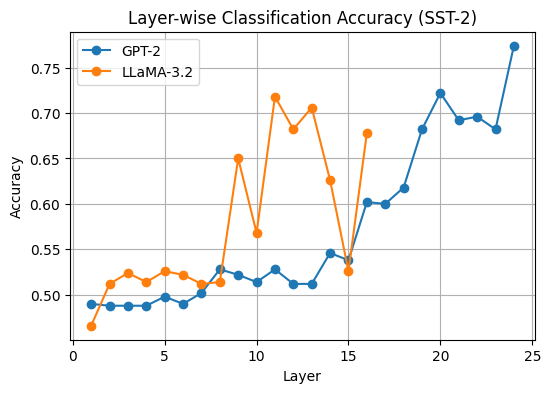

In [ ]:
import matplotlib.pyplot as plt

# unpack
gpt2_layers, gpt2_acc, gpt2_conf = unpack_stats(
    evaluate_per_layer_sst2(gpt2_early, cached_datasets["sst2"]["data"])
)

llama_layers, llama_acc, llama_conf = unpack_stats(
    evaluate_per_layer_sst2(llama_early, cached_datasets["sst2"]["data"])
)

plt.figure(figsize=(6,4))
plt.plot(gpt2_layers, gpt2_acc, marker="o", label="GPT-2")
plt.plot(llama_layers, llama_acc, marker="o", label="LLaMA-3.2")

plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title("Layer-wise Classification Accuracy (SST-2)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
thresholds = [0.3, 0.5, 0.7, 0.8, 0.9, 0.95]


In [ ]:
import numpy as np
import torch

@torch.no_grad()
def evaluate_thresholds_with_cache(
    model_name,
    exit_layers,
    thresholds,
    cached_datasets,
    dataset_name,
    device
):
    dataset = cached_datasets[dataset_name]["data"]
    results = []

    for th in thresholds:
        print(f"Running threshold = {th}")

        model = PromptNextTokenEarlyExit(
            model_name=model_name,
            exit_layers=exit_layers,
            threshold=th,
            device=device
        )

        correct = 0
        layers_used = []

        for sample in dataset:
            # SST-2 固定格式
            text = sample["sentence"]
            label = sample["label"]

            pred, layer, conf = model.classify(text, dataset_name)

            correct += int(pred == label)
            layers_used.append(layer)

        results.append({
            "threshold": th,
            "accuracy": correct / len(dataset),
            "avg_layers": float(np.mean(layers_used)),
        })

    return results


In [ ]:
thresholds = [0.3, 0.5, 0.7, 0.8, 0.9, 0.95]

# 全层 early-exit
gpt2_all_layers  = list(range(1, gpt2_early.num_layers + 1))
llama_all_layers = list(range(1, llama_early.num_layers + 1))

gpt2_threshold_results = evaluate_thresholds_with_cache(
    model_name=GPT2_MODEL,
    exit_layers=gpt2_all_layers,
    thresholds=thresholds,
    cached_datasets=cached_datasets,
    dataset_name="sst2",
    device=device
)

llama_threshold_results = evaluate_thresholds_with_cache(
    model_name=LLAMA_MODEL,
    exit_layers=llama_all_layers,
    thresholds=thresholds,
    cached_datasets=cached_datasets,
    dataset_name="sst2",
    device=device
)


Running threshold = 0.3
Running threshold = 0.5
Running threshold = 0.7
Running threshold = 0.8
Running threshold = 0.9
Running threshold = 0.95
Running threshold = 0.3
Running threshold = 0.5
Running threshold = 0.7
Running threshold = 0.8
Running threshold = 0.9
Running threshold = 0.95


In [ ]:
def unpack_threshold_results(results, key):
    x = [r["threshold"] for r in results]
    y = [r[key] for r in results]
    return x, y


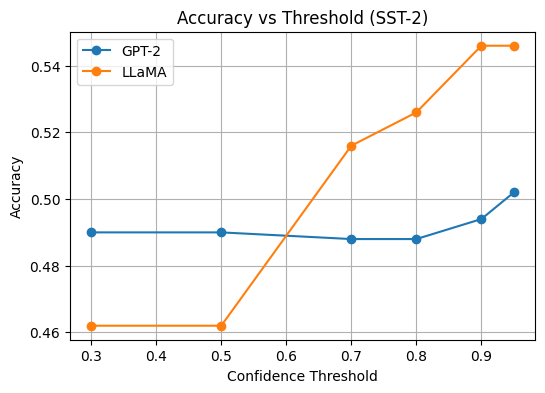

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

x, y = unpack_threshold_results(gpt2_threshold_results, "accuracy")
plt.plot(x, y, "o-", label="GPT-2")

x, y = unpack_threshold_results(llama_threshold_results, "accuracy")
plt.plot(x, y, "o-", label="LLaMA")

plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold (SST-2)")
plt.legend()
plt.grid(True)
plt.show()


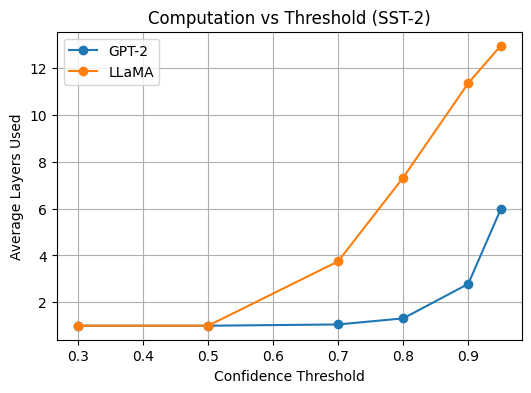

In [ ]:
plt.figure(figsize=(6,4))

x, y = unpack_threshold_results(gpt2_threshold_results, "avg_layers")
plt.plot(x, y, "o-", label="GPT-2")

x, y = unpack_threshold_results(llama_threshold_results, "avg_layers")
plt.plot(x, y, "o-", label="LLaMA")

plt.xlabel("Confidence Threshold")
plt.ylabel("Average Layers Used")
plt.title("Computation vs Threshold (SST-2)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

df_gpt2 = pd.DataFrame(gpt2_threshold_results)
df_llama = pd.DataFrame(llama_threshold_results)

df_gpt2["model"] = "GPT-2"
df_llama["model"] = "LLaMA-3.2"

df_all = pd.concat([df_gpt2, df_llama], ignore_index=True)


In [ ]:
print(df_all)


    threshold  accuracy  avg_layers      model
0        0.30     0.490       1.000      GPT-2
1        0.50     0.490       1.000      GPT-2
2        0.70     0.488       1.054      GPT-2
3        0.80     0.488       1.314      GPT-2
4        0.90     0.494       2.784      GPT-2
5        0.95     0.502       5.972      GPT-2
6        0.30     0.462       1.000  LLaMA-3.2
7        0.50     0.462       1.000  LLaMA-3.2
8        0.70     0.516       3.748  LLaMA-3.2
9        0.80     0.526       7.324  LLaMA-3.2
10       0.90     0.546      11.350  LLaMA-3.2
11       0.95     0.546      12.948  LLaMA-3.2


GPT-2 consistently exits at extremely shallow layers due to over-confident intermediate representations, resulting in near-random accuracy.
In contrast, LLaMA exhibits more conservative confidence behavior, requiring deeper layers to meet the threshold but achieving substantially higher accuracy.
These results suggest that softmax confidence is a poor early-exit signal, especially for well-calibrated models.


In [ ]:
print("=== GPT-2 ===")
print(df_gpt2.sort_values("threshold"))

print("\n=== LLaMA-3.2 ===")
print(df_llama.sort_values("threshold"))


=== GPT-2 ===
   threshold  accuracy  avg_layers  model
0       0.30     0.490       1.000  GPT-2
1       0.50     0.490       1.000  GPT-2
2       0.70     0.488       1.054  GPT-2
3       0.80     0.488       1.314  GPT-2
4       0.90     0.494       2.784  GPT-2
5       0.95     0.502       5.972  GPT-2

=== LLaMA-3.2 ===
   threshold  accuracy  avg_layers      model
0       0.30     0.462       1.000  LLaMA-3.2
1       0.50     0.462       1.000  LLaMA-3.2
2       0.70     0.516       3.748  LLaMA-3.2
3       0.80     0.526       7.324  LLaMA-3.2
4       0.90     0.546      11.350  LLaMA-3.2
5       0.95     0.546      12.948  LLaMA-3.2


In [ ]:
# GPT2_MODEL  = "gpt2-medium"
# LLAMA_MODEL = "unsloth/Llama-3.2-1B"
# device = "cuda" if torch.cuda.is_available() else "cpu"

# gpt2_baseline = PromptNextTokenBaseline(GPT2_MODEL, device=device)
# llama_baseline = PromptNextTokenBaseline(LLAMA_MODEL, device=device)

# gpt2_exit_layers  = [4, 8, 12, 16, 20]  # GPT2 24层
# llama_exit_layers = [3, 5, 8, 11, 13]   # 16层按比例映射

# gpt2_early  = PromptNextTokenEarlyExit(GPT2_MODEL, gpt2_exit_layers, threshold=0.8, device=device)
# llama_early = PromptNextTokenEarlyExit(LLAMA_MODEL, llama_exit_layers, threshold=0.8, device=device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]